##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [7]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Preview the downloaded image

With the test image downloaded, go ahead and display it.

segmentation_input_rotation0.jpg


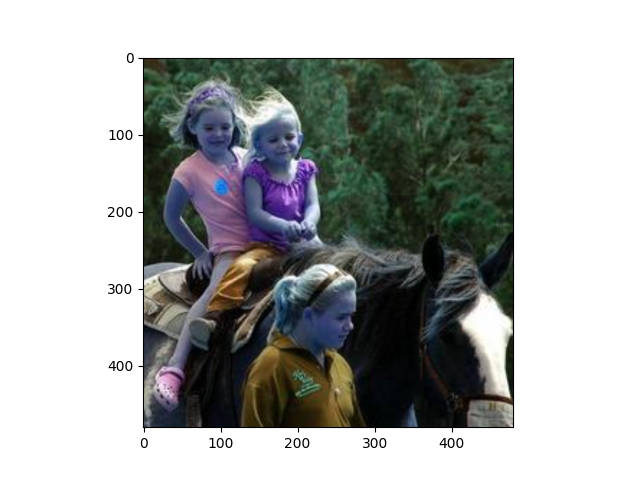

In [8]:
import cv2
import math
import matplotlib.pyplot as plt

# Height and width that will be used by the model
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

# Performs resizing and showing the image
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  plt.imshow(img)
  plt.show()


# Preview the image(s)
IMAGE_FILENAMES = ["segmentation_input_rotation0.jpg"]
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)
  resize_and_show(image)

## Running inference and visualizing the results
To run inference using the image segmentation MediaPipe Task, you will need to initialize the `ImageSegmenter` using the model. This example will separate the background and foreground of the image and apply separate colors for them to highlight where each distinctive area exists. Image segmentation here will use a category mask, which applies a category to each found item based on confidence.

Segmentation mask of segmentation_input_rotation0.jpg:


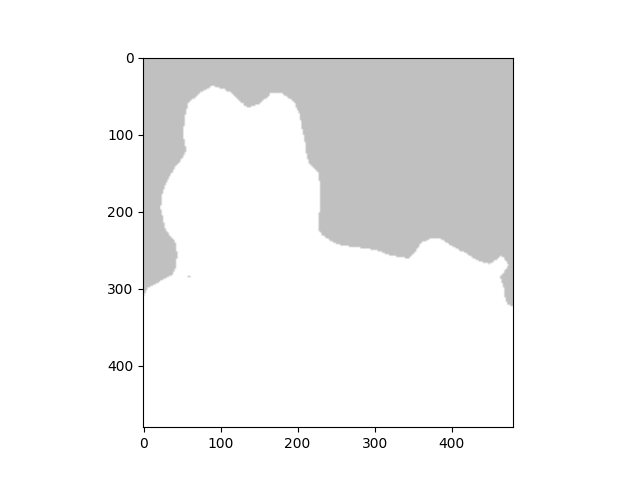

In [9]:
import numpy as np
import mediapipe as mp

from mediapipe.tasks import python
from mediapipe.tasks.python import vision


BG_COLOR = (192, 192, 192) # gray
MASK_COLOR = (255, 255, 255) # white


# Create the options that will be used for ImageSegmenter
base_options = python.BaseOptions(model_asset_path='deeplabv3.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

# Create the image segmenter
with vision.ImageSegmenter.create_from_options(options) as segmenter:

  # Loop through demo image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe image file that will be segmented
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the masks for the segmented image
    segmentation_result = segmenter.segment(image)
    category_mask = segmentation_result.category_mask

    # Generate solid color images for showing the output segmentation mask.
    image_data = image.numpy_view()
    fg_image = np.zeros(image_data.shape, dtype=np.uint8)
    fg_image[:] = MASK_COLOR
    bg_image = np.zeros(image_data.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR

    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.2
    output_image = np.where(condition, fg_image, bg_image)

    print(f'Segmentation mask of {name}:')
    resize_and_show(output_image)

Now that you know how to separate the foreground and background of an image, let's take it a step further and blur the background for an effect similar to what is provided by Google Hangouts.

Blurred background of segmentation_input_rotation0.jpg:


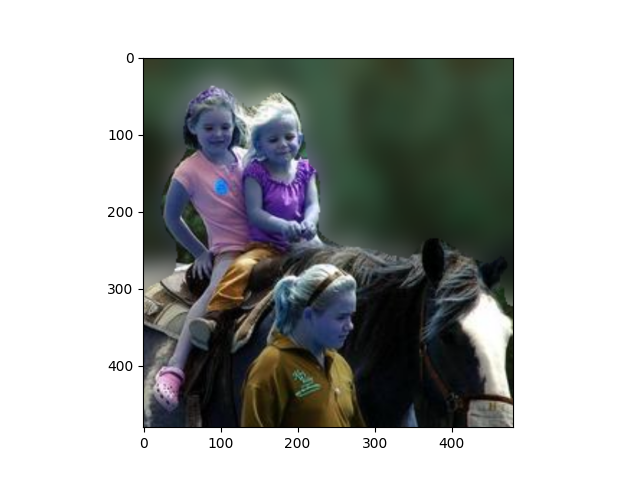

In [10]:
# Blur the image background based on the segmentation mask.

# Create the segmenter
with python.vision.ImageSegmenter.create_from_options(options) as segmenter:

  # Loop through available image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe Image
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the category masks for the image
    segmentation_result = segmenter.segment(image)
    category_mask = segmentation_result.category_mask

    # Convert the BGR image to RGB
    image_data = cv2.cvtColor(image.numpy_view(), cv2.COLOR_BGR2RGB)

    # Apply effects
    blurred_image = cv2.GaussianBlur(image_data, (55,55), 0)
    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.1
    output_image = np.where(condition, image_data, blurred_image)

    print(f'Blurred background of {image_file_name}:')
    resize_and_show(output_image)

In [11]:
from pathlib import Path

DATA_ROOT = Path("../../data/")
# VIDEO_NAME = Path("VID_20230814_102451798.mp4")
VIDEO_NAME = Path("private/VID_20230815_160238697.mp4")
MODEL_NAME = Path("models/selfie_segmenter.onnx")

# check if the video exists
if not (DATA_ROOT / VIDEO_NAME).exists():
    raise FileNotFoundError(f"Video not found: {DATA_ROOT / VIDEO_NAME}")

# open video file with opencv
video_reader = cv2.VideoCapture(str(DATA_ROOT/VIDEO_NAME))

# check if video opened successfully
if (video_reader.isOpened() == False):
    raise Exception(f"Error opening video stream or file: {DATA_ROOT/VIDEO_NAME}")
    
width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
# print video properties
print("Video properties:")
print("  - frame width:  ", width)
print("  - frame height: ", height)
print("  - frame count:  ", frames_count)
print("  - frame rate:   ", video_reader.get(cv2.CAP_PROP_FPS))

Video properties:
  - frame width:   1080
  - frame height:  1920
  - frame count:   90
  - frame rate:    30.0


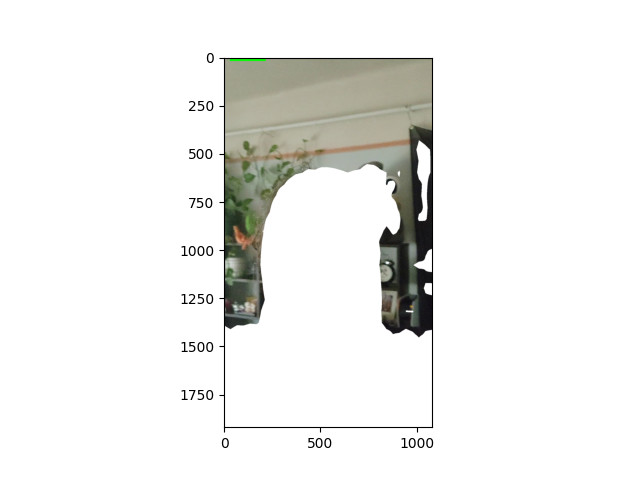

KeyboardInterrupt: 

In [23]:
from tqdm import tqdm
from IPython.display import clear_output
video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)
scene_3d = []

plt.ion()
fig, ax = plt.subplots()
fig.canvas.draw()
with python.vision.ImageSegmenter.create_from_options(options) as segmenter:
    for frame_index in range(10, frames_count-1): # tqdm(range(frames_count - 2)):
        _, frame = video_reader.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

        # Retrieve the masks for the segmented image
        segmentation_result = segmenter.segment(image)
        category_mask = segmentation_result.category_mask

        # Generate solid color images for showing the output segmentation mask.
        image_data = image.numpy_view()
        fg_image = np.zeros(image_data.shape, dtype=np.uint8)
        fg_image[:] = MASK_COLOR
        bg_image = np.zeros(image_data.shape, dtype=np.uint8)
        bg_image[:] = image_data #BG_COLOR

        condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.2
        output_image = np.where(condition, fg_image, bg_image)

        # resize_and_show(output_image)
        # Update the image content
        
        
        #draw a progress bar on the image
        cv2.rectangle(output_image, (30, 20), (int(output_image.shape[1]*frame_index/frames_count), 10), (0, 255, 0), -1)
        #cv2.rectangle(output_image, (30, 20), (70, 50), (0, 255, 0), -1)
        clear_output(wait=True)
        ax.clear()
        # create plot
        im = ax.imshow(output_image)
        
        # Re-render the figure and give the GUI event loop the chance to update itself
        # Instead of the two lines one can use "plt.pause(0.001)" which, however gives a
        # decepracted warning.
        # See https://github.com/matplotlib/matplotlib/issues/7759/ for an explanation.
        fig.canvas.flush_events()
        plt.pause(0.1)

        

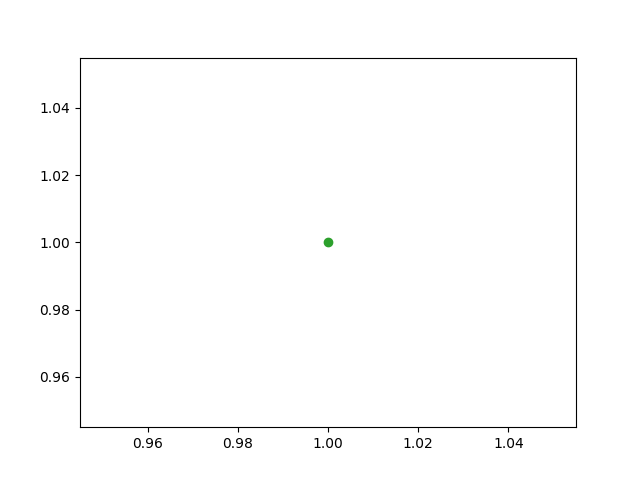

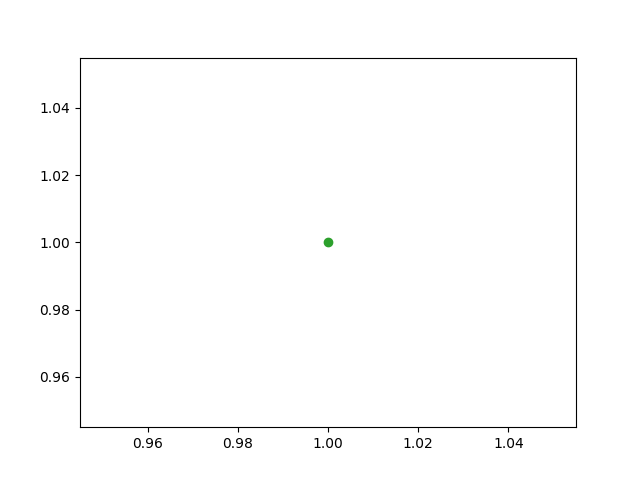

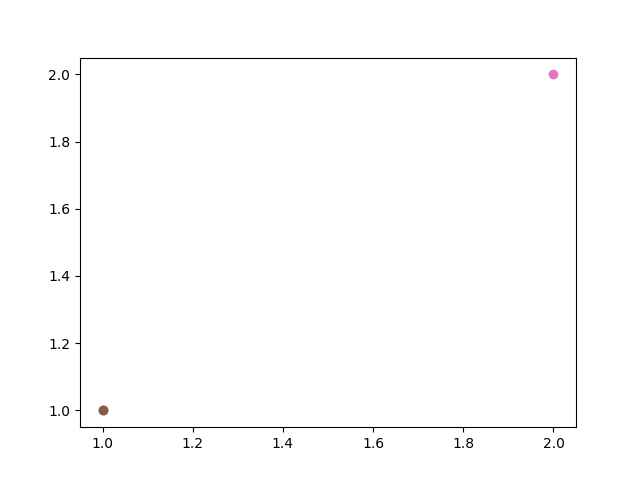

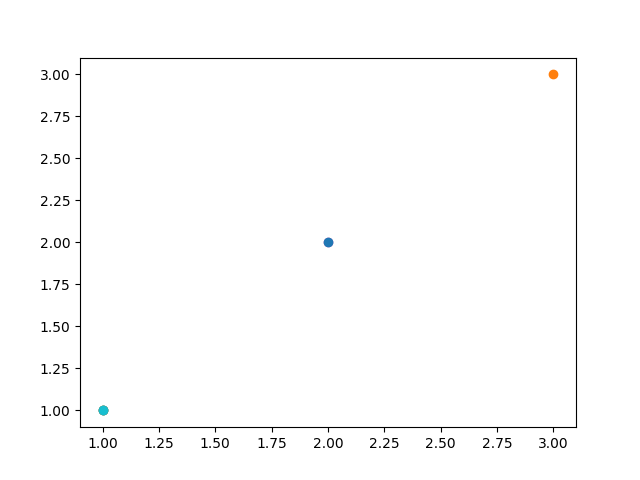

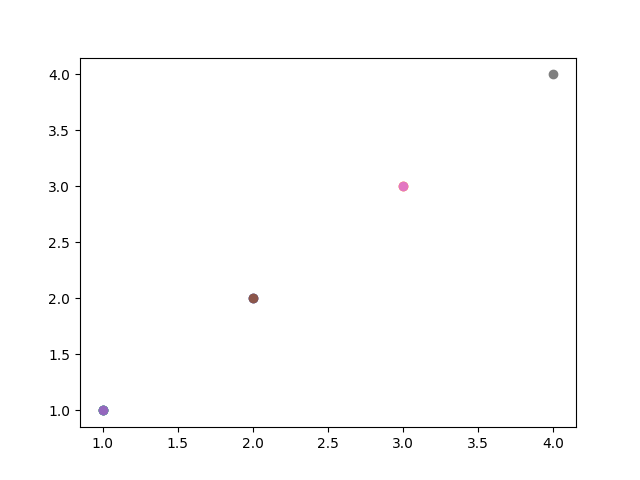

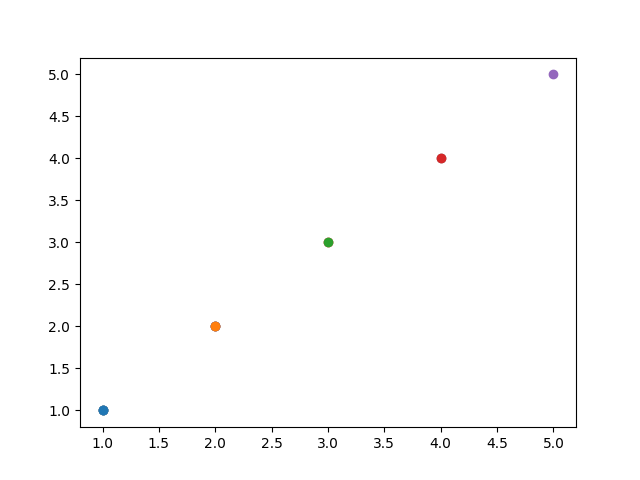

In [26]:
x=[1,2,3,4,5]
y=[1,2,3,4,5]
currentLastPoint = 0
fig, ax=plt.subplots()
while currentLastPoint < len(x):
    currentLastPoint += 1
    plt.plot(x[0],y[0])
    plt.plot([],[])
    for i in range(0,currentLastPoint):
        plt.plot(x[i],y[i],'o')
    plt.pause(0.1)
    if currentLastPoint == 1:
        plt.show()
    else:
        plt.draw()